# TP2 : Optimisation avec contraintes

## Exercice 1 : mise en oeuvre d'une méthode de gradient projeté et de pénalisation

$$J(x, y) = 2x^2 + 3xy + 2y^2$$
$$Q = \{ x \leq - \frac{1}{2}, y \leq - \frac{1}{2} \}$$


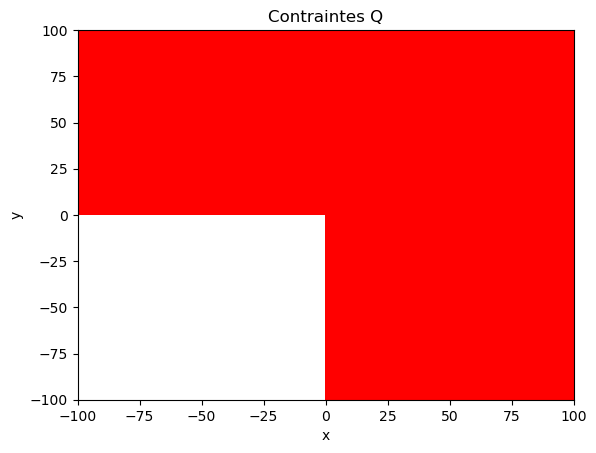

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-100, 100, 1000)
y = np.linspace(-100, 100, 1000)
X, Y = np.meshgrid(x, y)
Z = ((X <= -1 / 2) & (Y <= -1 / 2)).astype(int)

plt.contourf(X, Y, Z, levels=[-1, 0, 1], colors=["#FF0000", "#FFFFFF", "#0000FF"])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Contraintes Q")
plt.show()

Analyse théorique du problème :

a) Sans contraintes:

On cherche les points critiques:

$$\nabla J(x, y) = \begin{bmatrix} 4x + 3y \\ 3x + 4y \end{bmatrix}$$

$$
\begin{align*}
\begin{cases} 4x + 3y = 0 \\ 3x + 4y = 0 \end{cases}
\end{align*}
$$

Avec un pivot de Gauss, on trouve que le seul point critique est $(0, 0)$.  
On cherche maintenant à déterminer la nature de ce point critique:

$$\nabla^2 J(x, y) = \begin{bmatrix} 4 & 3 \\ 3 & 4 \end{bmatrix}$$

$\forall (x, y) \in \mathbb{R}^2,  \nabla^2 J(x, y)$ est **symétrique définie positive**  car elle est symétrique à diagonale strictement dominante et les coefficients diagonaux sont $> 0$.  
(ou bien avec les valeurs propres : $\chi_{Hess(J)}(\lambda) = \lambda^2 - 8\lambda + 7 \Rightarrow \lambda_1 = 1, \lambda_2 = 7 > 0$)  

Donc $J(x, y)$ est **strictement convexe** pour tout $(x, y) \in \mathbb{R}^2$.  
Donc $\bar{X} = (0, 0)$ est l'**unique minimum global** de $J(x, y)$ dans $\mathbb{R}^2$.

b) Avec contraintes:
\begin{align*}
(\bar{X} \text{ min de } J \text{ sous la contrainte } \bar{X} \in Q) \Longrightarrow (\nabla J(\bar{X}) = 0 \text{ ou } X \in \partial Q)
\end{align*}

- Cas 1, $\bar{X} \in Q$ est également un min sans contraintes:  
  Si $\nabla J(\bar{X}) \neq 0$, alors on peu trouver une direction de descente $d$ et un pas $s$ tel que $J(\bar{X} + sd) < J(\bar{X})$ dans un voisinage de $\bar{X}$.  
  Ce qui contredit le fait que $\bar{X}$ est un minimum local.  
  Donc $\nabla J(\bar{X}) = 0$.

- Cas 2, $\bar{X} \in Q$ n'est pas un min sans contraintes:  
  On sait que l'unique min global est $\bar{X} = (0, 0)$, or $(0, 0) \notin Q$.  
  Donc le min sous la contrainte va être le plus proche possible du vrai min $(0, 0)$ donc forcement sur le bord des contraintes.  
  Et donc $\bar{X} \in \partial Q$ et $\bar{X} = (-\frac{1}{2}, -\frac{1}{2})$.


### Méthode de gradient projeté pour $\inf\limits_{(x,y) \in Q} J(x,y)$

In [2]:
# operateur de projection sur l'ensemble Q = {(x, y) | x <= -1/2 et y <= -1/2}
def projection_Q(x, y):
    return (min(x, -1 / 2), min(y, -1 / 2))


print(projection_Q(0, 0))

(-0.5, -0.5)


In [3]:
def grad_projete(J, gradJ, x0, s, eps=1e-10, max_iter=1000000):
    x = x0
    iterates = [x]
    k = 0
    while k < max_iter:
        gradJ_x = gradJ(x)
        x_prev = x
        x = projection_Q(x[0] - s * gradJ_x[0], x[1] - s * gradJ_x[1])
        iterates.append(x)
        if np.linalg.norm(J(x) - J(x_prev)) < eps:
            break
        k += 1
    if k == max_iter:
        print(
            "La methode à pas optimal n'a pas convergé pour eps={} en {} itérations".format(
                eps, max_iter
            )
        )
    return iterates

Gradient projeté : X_ = (-0.5, -0.5) en 3 iterations
J(-0.5, -0.5) = 1.75


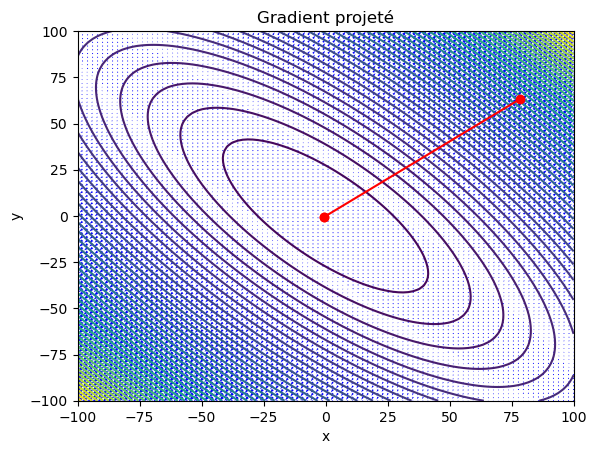

In [4]:
J = lambda x: 2 * x[0] ** 2 + 3 * x[0] * x[1] + 2 * x[1] ** 2
gradJ = lambda x: np.array([4 * x[0] + 3 * x[1], 3 * x[0] + 4 * x[1]])


x0 = np.random.uniform(-100, 100, 2)
iterates = grad_projete(J, gradJ, x0, s=0.01)

print("Gradient projeté : X_ = {} en {} iterations".format(iterates[-1], len(iterates)))
print("J{} = {}".format(iterates[-1], J(iterates[-1])))

x = np.linspace(-100, 100, 100)
y = np.linspace(-100, 100, 100)
X, Y = np.meshgrid(x, y)
Z = J([X, Y])

plt.contour(X, Y, Z, levels=50)
plt.quiver(X, Y, gradJ([X, Y])[0], gradJ([X, Y])[1], color="b")
plt.plot(*zip(*iterates), "ro-")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gradient projeté")
plt.show()

On remarque donc que la solution du problème de minimisation sous la contrainte $Q$ est différente de la solution du problème sans contrainte ce qui n'est pas étonnant car $(0,0)\notin Q$.


### Méthode de pénalisation

In [5]:
# fonction de pénalisation
def phi(x):
    return np.linalg.norm(np.maximum(0, x[0] + 1 / 2)) + np.linalg.norm(
        np.maximum(0, x[1] + 1 / 2)
    )


def grad_phi(x):
    return np.array([np.maximum(0, x[0] + 1 / 2), np.maximum(0, x[1] + 1 / 2)])

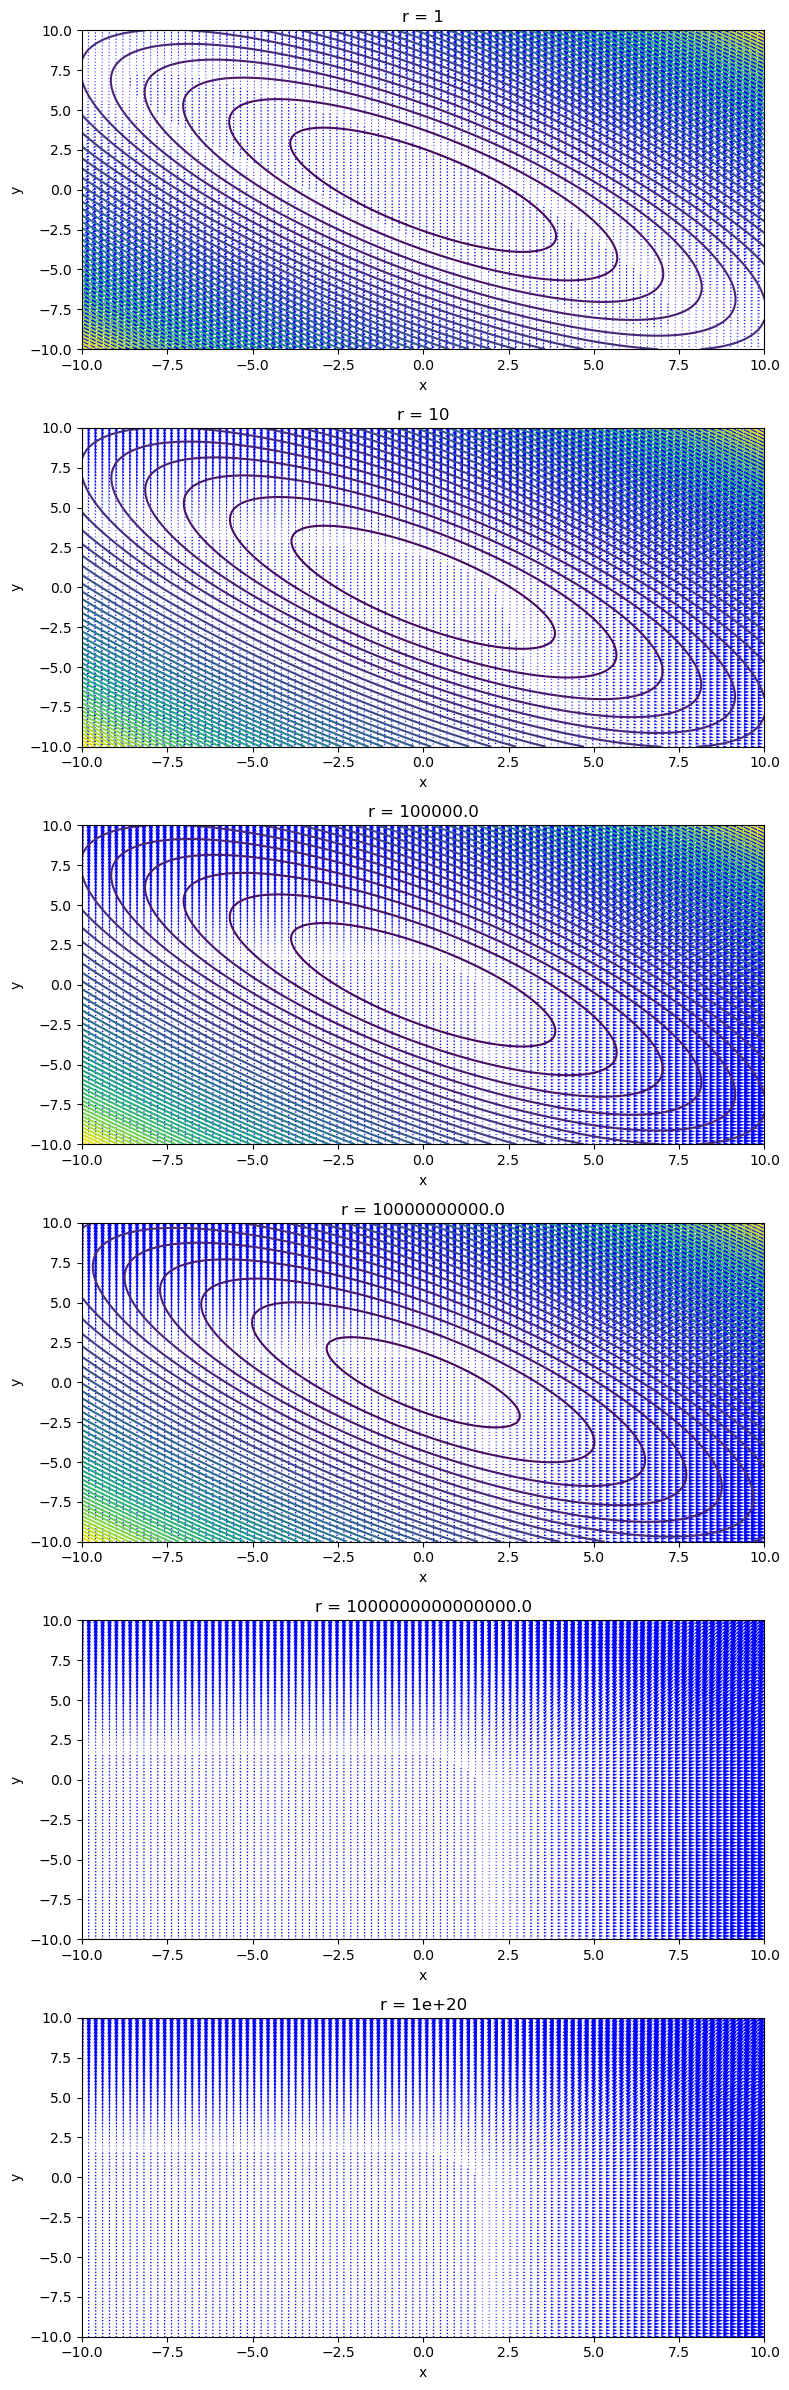

In [6]:
J_penalise = lambda x, r: J(x) + r * phi(x)
gradJ_penalise = lambda x, r: gradJ(x) + r * grad_phi(x)

penalisation_coef = [1, 10, 1e5, 1e10, 1e15, 1e20]

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)

fig, axs = plt.subplots(len(penalisation_coef), figsize=(8, len(penalisation_coef) * 4))

for ax, r in zip(axs, penalisation_coef):
    Z = J_penalise([X, Y], r)
    ax.contour(X, Y, Z, levels=50)
    ax.quiver(
        X, Y, gradJ_penalise([X, Y], r)[0], gradJ_penalise([X, Y], r)[1], color="b"
    )
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_title("r = {}".format(r))

plt.tight_layout()
plt.show()

On remarque que plus on augmente le coefficient de pénalisation, plus le champs de
gradient de la fonction coût est intense sur les bords de la contrainte $Q$. On devrait donc pouvoir utiliser une méthode de gradient sans contraintes pour trouver la solution du problème avec contraintes.


In [7]:
def gradient_pas_fixe(J, gradJ, x0, s, r, eps=1e-8, max_iter=100_000):
    x = x0
    iterates = [x0]
    k = 0
    while k < max_iter:
        gradx = gradJ(x, r)
        x = x - s * gradx
        iterates.append(x)
        if np.linalg.norm(gradJ(x, r)) < eps:
            break
        k += 1
    if k == max_iter:
        print(
            "La methode à pas fixe n'a pas convergé pour eps={} en {} itérations".format(
                eps, max_iter
            )
        )
    return iterates

Gradient pas fixe : X_ = [-0.49652433 -0.49652433] en 7 iterations
J[-0.49652433 -0.49652433] = 1.7257548698449015


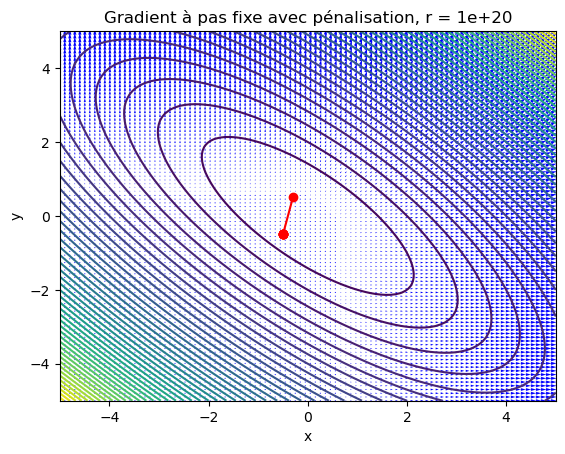

In [8]:
x0 = (-0.3, 0.5)

iterates = gradient_pas_fixe(J_penalise, gradJ_penalise, x0, s=0.001, r=1e3)

print(
    "Gradient pas fixe : X_ = {} en {} iterations".format(iterates[-1], len(iterates))
)
print("J{} = {}".format(iterates[-1], J(iterates[-1])))

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = J([X, Y])

plt.contour(X, Y, Z, levels=50)
plt.quiver(
    X,
    Y,
    gradJ_penalise([X, Y], r)[0],
    gradJ_penalise(
        [
            X,
            Y,
        ],
        r,
    )[1],
    color="b",
)
plt.plot(*zip(*iterates), "ro-")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gradient à pas fixe avec pénalisation, r = {}".format(r))
plt.show()

On remarque qu'avec un coefficient de pénalisation élevé, la methode de gradient à
pas fixe converge très rapidement vers la bonne solution du probleme avec contrainte.


Gradient à pas fixe : X_ = [-0.11346658 -0.10875556] en 1710 iterations
J[-0.11346658 -0.10875556] = 0.08642523751537742


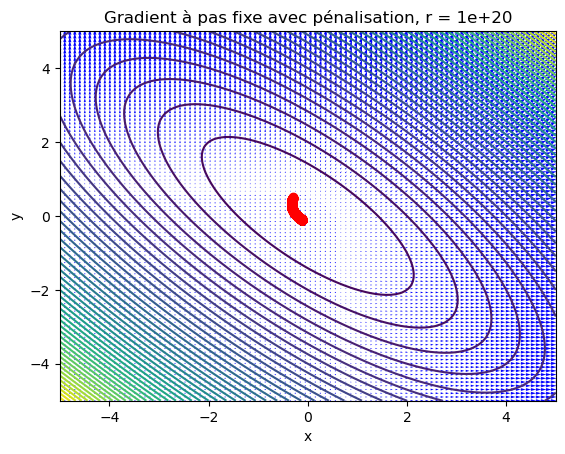

In [9]:
x0 = (-0.3, 0.5)

iterates = gradient_pas_fixe(J_penalise, gradJ_penalise, x0, s=0.001, r=2, eps=1e-2)

print(
    "Gradient à pas fixe : X_ = {} en {} iterations".format(iterates[-1], len(iterates))
)
print("J{} = {}".format(iterates[-1], J(iterates[-1])))

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = J([X, Y])

plt.contour(X, Y, Z, levels=50)
plt.quiver(
    X,
    Y,
    gradJ_penalise([X, Y], r)[0],
    gradJ_penalise(
        [
            X,
            Y,
        ],
        r,
    )[1],
    color="b",
)
plt.plot(*zip(*iterates), "ro-")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gradient à pas fixe avec pénalisation, r = {}".format(r))
plt.show()

Alors qu'avec un coefficent de pénalisation faible, la méthode de gradient à pas
fixe converge plutot vers la solution du problème sans contrainte mais reste relativement loin de la solution exacte.


In [10]:
def methode_doree(f, a, b, tol):
    tau = (np.sqrt(5) - 1) / 2
    x1 = a + (1 - tau) * (b - a)
    x2 = a + tau * (b - a)
    f1 = f(x1)
    f2 = f(x2)
    while b - a > tol:
        if f1 < f2:
            b = x2
            x2 = x1
            f2 = f1
            x1 = a + (1 - tau) * (b - a)
            f1 = f(x1)
        else:
            a = x1
            x1 = x2
            f1 = f2
            x2 = a + tau * (b - a)
            f2 = f(x2)
    return (a + b) / 2

In [11]:
def gradient_pas_optimal(J, gradJ, x0, r, eps=1e-8, max_iter=100_000):
    x = x0
    iterates = [x0]
    k = 0
    while k < max_iter:
        gradx = gradJ(x, r)
        x_prev = x
        # methode doree requiert J unimodale
        s = methode_doree(lambda s: J(x - s * gradx, r), 0.001, 2, 1e-5)
        x = x - s * gradx
        iterates.append(x)
        if np.linalg.norm(gradJ(x, r)) < eps:
            break
        # if np.linalg.norm(J(x_prev, r) - x) < eps:
        #     break
        k += 1
    if k == max_iter:
        print(
            "La methode à pas optimal n'a pas convergé pour eps={} en {} itérations".format(
                eps, max_iter
            )
        )
    return iterates

Gradient à pas optimal : X_ = [-0.49652084 -0.49651503] en 5 iterations
J[-0.49652084 -0.49651503] = 1.7257104149230225


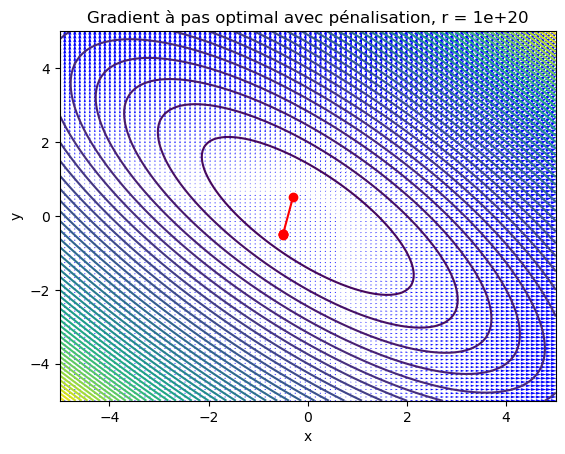

In [12]:
x0 = (-0.3, 0.5)

iterates = gradient_pas_optimal(J_penalise, gradJ_penalise, x0, r=1e3, eps=1e-2)

print(
    "Gradient à pas optimal : X_ = {} en {} iterations".format(
        iterates[-1], len(iterates)
    )
)
print("J{} = {}".format(iterates[-1], J(iterates[-1])))

x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = J([X, Y])

plt.contour(X, Y, Z, levels=50)
plt.quiver(
    X,
    Y,
    gradJ_penalise([X, Y], r)[0],
    gradJ_penalise(
        [
            X,
            Y,
        ],
        r,
    )[1],
    color="b",
)
plt.plot(*zip(*iterates), "ro-")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gradient à pas optimal avec pénalisation, r = {}".format(r))
plt.show()

Encore une fois le plus délicat reste à trouver les bons hyperparamètres...  
Ca converge en 2 itérations de moins qu'avec un pas fixe de 0.001


## Exercice 2 : méthode de type gradient pour les fonctions quadratiques

$$K=\Biggl\{ x \in \mathbb{R}^{n} : \begin{pmatrix} u^{T} & e^{T} \end{pmatrix}X= \begin{pmatrix}1 \\ r_{0} \end{pmatrix} \Biggl\}$$

D'apres le théoreme de Karush-Kuhn-Tucker, on a que si $\bar{x}$ est un minimum local de $f$ et que les contraintes sont qualifiées en ce point, alors,

$\exists \lambda_{1}, .... , \lambda_{p} \in \mathbb{R}$ et $\mu_{1}, .... , \mu_{m} \in \mathbb{R}_{+}$ non tous nuls, tels que:

$$
\begin{cases}
\nabla J(\bar{x}) + \sum_{i=1}^{p} \lambda_{i} \nabla h_{i}(\bar{x}) + \sum_{j=1}^{m} \mu_{j} \nabla g_{j}(\bar{x}) = 0 \\
\forall j \in \{1, ..., m\}, \mu_{j}g_{j}(\bar{x}) = 0
\end{cases}
$$

où h et g sont les contraintes d'égalité et d'inégalité respectivement.


Ici on n'a que des contraintes d'égalité, donc on a:

$$
\begin{cases}
\nabla J(x) + \lambda_{1} \nabla h_{1}(x) + \lambda_{2} \nabla h_{2}(x) = 0 \\
h_{1}(x) = 0 \\
h_{2}(x) = 0
\end{cases}
$$

où :

$ \nabla J(x) = Ax - b $

$ h*{1}(x) = u^{T}x - 1 $ et $ h*{2}(x) = e^{T}x - r_{0} $ , contraites d'égalité

$ \nabla h*{1}(x) = u $ et $ \nabla h*{2}(x) = e $ , contraintes d'égalité


Sous forme matricielle, on a donc:

$$
\begin{pmatrix}
A & -u & -e \\
u^{T} & 0 & 0 \\
e^{T} & 0 & 0
\end{pmatrix}
\begin{pmatrix}
x \\
\lambda_{1} \\
\lambda_{2}
\end{pmatrix}
=
\begin{pmatrix}
b \\
1 \\
r_{0}
\end{pmatrix}
$$

Les contraintes sont qualifiées car affines.


In [13]:
n = 5
r0 = 2.5


def A(n):
    e = np.zeros(n)
    for i in range(1, n + 1):
        e[i - 1] = i
    A = np.diag(e)
    R = np.random.rand(n, n)
    A = A + 0.05 * (np.transpose(R) @ R)
    # A est diag, R.T @ R est symétrique, donc apres addition A est symétrique à
    # diagonale dominante >0 donc A est symétrique définie positive
    return A


print(A(5))

[[1.06455988 0.06033241 0.07772116 0.02968551 0.06300668]
 [0.06033241 2.06402269 0.07089766 0.027837   0.05960318]
 [0.07772116 0.07089766 3.1081727  0.05218542 0.09094138]
 [0.02968551 0.027837   0.05218542 4.08538719 0.07368199]
 [0.06300668 0.05960318 0.09094138 0.07368199 5.10043344]]


In [14]:
def uzawa(A, b, r, x0, s, eps=1e-8, max_iter=100_000):
    x = x0
    y = np.zeros_like(b)
    k = 0
    iterates = [x]
    while k < max_iter:
        x = x - s * (A @ x - b + y)
        y = np.maximum(0, y + r * (A @ x - b))
        iterates.append(x)
        if np.linalg.norm(A @ x - b) < eps:
            break
        k += 1
    if k == max_iter:
        print(
            "La methode d'Uzawa n'a pas convergé pour eps={} en {} itérations".format(
                eps, max_iter
            )
        )
    return iterates

In [15]:
N = [2, 10, 50, 100, 500]

for n in N:
    A_ = A(n)
    cond = np.linalg.cond(A_)
    print("Conditionnement de A{} : {}".format(n, cond))
    b = np.random.rand(n)
    x0 = np.random.rand(n)
    iterates = uzawa(A(n), b, r0, x0, s=0.001)
    print("Uzawa : en {} iterations".format(len(iterates)))

Conditionnement de A2 : 1.9594657894163177
Uzawa : en 16382 iterations
Conditionnement de A10 : 9.372705025680188
Uzawa : en 14558 iterations
Conditionnement de A50 : 47.390014992756704
Uzawa : en 11749 iterations
Conditionnement de A100 : 111.56378548969785
Uzawa : en 4504 iterations
Conditionnement de A500 : 1013.1654141877281


/tmp/ipykernel_11653/1471962957.py:8: RuntimeWarning: overflow encountered in matmul
  y = np.maximum(0, y + r * (A @ x - b))
/tmp/ipykernel_11653/1471962957.py:10: RuntimeWarning: overflow encountered in matmul
  if np.linalg.norm(A @ x - b) < eps:
/tmp/ipykernel_11653/1471962957.py:7: RuntimeWarning: overflow encountered in matmul
  x = x - s * (A @ x - b + y)
/tmp/ipykernel_11653/1471962957.py:7: RuntimeWarning: invalid value encountered in subtract
  x = x - s * (A @ x - b + y)


La methode d'Uzawa n'a pas convergé pour eps=1e-08 en 100000 itérations
Uzawa : en 100001 iterations


Inconvenient majeur de cette méthode : il y a une résolution implicite d'une système linéaire.  
Si $A$, la matrice du système, est mal conditionné le système sera instable face au conditions initiales.  
Pour essayer d'y remedier, on peut tenter  d'utilisé un preconditionneur (LU, Cholesky, etc...) sur $A$ .


In [16]:
n = 1000
A_ = A(n)
L = np.linalg.cholesky(A_)  # choleski OK car A SDP
cond = np.linalg.cond(A_)
print("Conditionnement de A{} : {}".format(n, cond))
b = np.random.rand(n)
x0 = np.random.rand(n)
iterates = uzawa(L, b, r0, x0, s=0.001)
print("Uzawa en {} iterations".format(len(iterates)))

Conditionnement de A1000 : 2580.8053012053574
Uzawa en 4670 iterations
